In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
dataArima = pd.read_parquet("Data/agg_table_new_zones8Bot.parquet")
#The already binned and aggregated dataset


In [ ]:
dataArima = dataArima[dataArima["h3_index"] == "88329b5aa1fffff"]
#As ARIMA cannot process all zones at ones, we choose the one for comparance

In [ ]:
dataArima = dataArima.drop(columns=("h3_index"))
dataArima["time_bin"] = pd.to_datetime(dataArima["time_bin"])
dataArima.set_index("time_bin",inplace=True)
#drop index and set time bin as index

In [ ]:
size = int(len(dataArima) * 0.875)
train, test = dataArima.iloc[0:size], dataArima.iloc[size:len(dataArima)]

y_train_log = np.log1p(train["order_count"])
y_test_log = np.log1p(test["order_count"])

#Create test and train split - forgot the validation data oops

In [ ]:
def create_fourier_features(index, seasonal_period, k):
#To improve the performance
    n_samples = len(index)
    time = np.arange(n_samples)
    features = {}
    for i in range(1, k + 1):
        features[f'sin_{i}'] = np.sin(2 * np.pi * i * time / seasonal_period)
        features[f'cos_{i}'] = np.cos(2 * np.pi * i * time / seasonal_period)
    return pd.DataFrame(features, index=index)

In [ ]:
seasonal_period = 96  # A day (24*4)
k = 4                 # Number of fourier pairs
X_train_fourier = create_fourier_features(y_train_log.index, seasonal_period, k)
X_test_fourier = create_fourier_features(y_test_log.index, seasonal_period, k)
# -------------------------------------------------------------------------
# prepare SARIMAX manually
model = SARIMAX(y_train_log,
                exog=X_train_fourier,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0))

model_fit = model.fit(disp=False)
print(model_fit.summary())

# Prediction of the model
forecast_log = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test_fourier)
forecast = np.expm1(forecast_log)

                               SARIMAX Results                                
Dep. Variable:            order_count   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -203.329
Date:                Fri, 29 Aug 2025   AIC                            428.658
Time:                        10:47:34   BIC                            478.255
Sample:                    10-17-2022   HQIC                           447.867
                         - 10-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -1.1806      0.032    -37.078      0.000      -1.243      -1.118
cos_1         -0.7273      0.033    -21.763      0.000      -0.793      -0.662
sin_2         -0.4584      0.034    -13.533      0.0

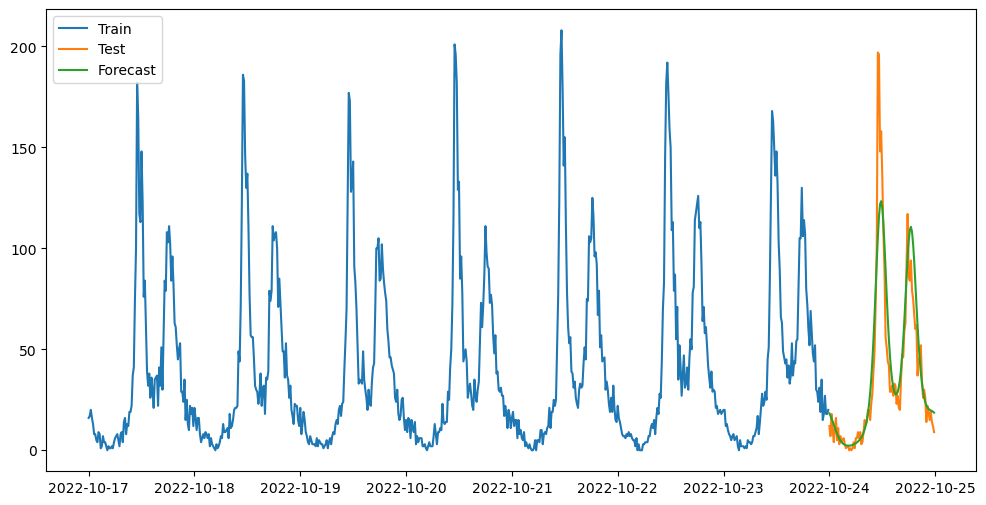

In [ ]:
#Plot for the index
plt.figure(figsize=(12,6))
plt.plot(train.index, train["order_count"], label="Train")
plt.plot(test.index, test["order_count"], label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

In [ ]:
#Calculate metrics
actual = test["order_count"]
mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(actual, forecast)

nonzero_indices = actual != 0
actual = actual.values
forecast = forecast.values

if np.any(nonzero_indices):
    mape = np.mean(np.abs((actual[nonzero_indices] - forecast[nonzero_indices]) / actual[nonzero_indices])) * 100
else:
    mape = np.nan
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

MAE  : 9.93
MSE  : 292.64
RMSE : 17.11
MAPE : 39.56%
R²   : 0.8305


In [ ]:
np.save('prognose_arima.npy', forecast) #save for comparance